In [1]:
%cd -q ../..

%load_ext autoreload
%autoreload 2

In [4]:
import json
import os
from collections import Counter, defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
from dotenv import load_dotenv
from matplotlib import pyplot as plt
from numpy.polynomial import polynomial

from scotus_metalang.diachronic_analysis import authors, prediction_graphing

In [5]:
load_dotenv()
data_path = os.environ["SCOTUS_METALANG_DATA_PATH"]
model_name = "binary_token_model_bert_large_8_epochs"

### Read prediction data


In [4]:
rows = []
prediction_counts = {}  # Nested dict: author, year, category
token_counts = {}  # Nested dict: author, year
#conservative_justices = [x for x in authors.JUSTICE_TO_IDEOLOGY if authors.JUSTICE_TO_IDEOLOGY[x] == "liberal"]
for author in authors.ORDERED_JUSTICES:
    author_prediction_counts = defaultdict(lambda: {"ft": 0, "mc": 0, "dq": 0, "les": 0})
    author_token_counts = Counter()
    for opinion_path in Path(f"{data_path}/cap/known_authors/{author}").glob("*.json"):
        with open(opinion_path, "r") as f:
            case = json.load(f)
            term = case["term"]
            opinion_type = case["type"]

        docket_number = case["docket"]
        filename = opinion_path.stem + ".txt"
        prediction_path = Path(f"{data_path}/predictions", model_name, author, filename)
        scores = np.loadtxt(prediction_path)
        threshold = .60
        num_tokens = len(scores)
        predictions = scores > threshold
        ft, mc, dq, les = np.sum(predictions, axis=0)
        row = [docket_number, author, opinion_type, term, num_tokens, ft, mc, dq, les]
        rows.append(row)
columns = ["docket_number", "author", "opinion_type", "term", "tokens", "ft", "mc", "dq", "les"]
df_all = pd.DataFrame(rows, columns=columns)
df_18 = df_all[df_all["term"].astype(int) < 2019]  # Exclude 2019 data because that's training data
df_18.head()

,docket_number,author,opinion_type,term,tokens,ft,mc,dq,les
0,86-1088,brennan,concurrence,1988,37,0,0,0,3
1,86-39,brennan,majority,1986,10770,26,110,1989,2780
2,88-515,brennan,concurring-in-part-and-dissenting-in-part,1988,849,3,10,155,243
3,87-548,brennan,dissent,1988,4067,17,11,568,543
4,88-2031,brennan,dissent,1989,11876,24,32,2652,2798


In [ ]:
def plot_cases_per_term(df):
    cases_per_term = dict(df.groupby('term')["docket_number"].nunique())
    plt.plot(cases_per_term.keys(), cases_per_term.values())
    title = "Cases per SCOTUS Term"
    plt.title(title)
    plt.xticks(rotation=90)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_cases_per_term(df_18)

In [ ]:
def plot_avg_opinions_per_case(df):
    cases_per_term = dict(df.groupby('term')["docket_number"].nunique())
    opinions_per_term = dict(df.groupby("term").size())
    average_per_term = [opinions_per_term[term] / cases_per_term[term] for term in cases_per_term]
    plt.plot(cases_per_term.keys(), average_per_term)
    title = "Opinions per Case"
    plt.title(title)
    plt.xticks(rotation=90)
    plt.ylim(1, 3)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_avg_opinions_per_case(df_18)

In [ ]:
def plot_opinion_length_per_term(df):
    tokens_per_term = dict(df.groupby("term")["tokens"].mean())
    plt.plot(tokens_per_term.keys(), tokens_per_term.values())
    title = "Wordpiece Tokens per Opinion"
    plt.title(title)
    plt.xticks(rotation=90)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_opinion_length_per_term(df_18)

In [ ]:
def plot_frequency_by_author(category, df):
    cat_by_author = dict(df.groupby(['author'])[category].sum())
    tokens_by_author = dict(df.groupby(['author'])["tokens"].sum())
    frequencies_by_author = [cat_by_author[a] / tokens_by_author[a] for a in authors.ORDERED_JUSTICES]
    plt.xticks(rotation=90)
    plt.bar(authors.ORDERED_JUSTICES.keys(), frequencies_by_author)
    title = f"Rates of {category} by Author"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_frequency_by_author("dq", df_18)

In [ ]:
def plot_frequency_by_term(category, df):
    cat_by_term = dict(df.groupby(["term"])[category].sum())
    tokens_by_term = dict(df.groupby(["term"])["tokens"].sum())
    frequencies_by_term = [cat_by_term[term] / tokens_by_term[term] for term in cat_by_term]
    plt.xticks(rotation=90)
    plt.bar(cat_by_term.keys(), frequencies_by_term)
    title = f"Rates of {category} by Term"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_frequency_by_term("ft", df_18)

In [17]:
df_18["ft_rate"] = df_18.ft / df_18.tokens

In [19]:
df_grouped = df_18[["term", "ft_rate"]].groupby(["term"]).agg(["mean", "std", "count"])

df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
# Calculate a confidence interval as well.
df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']
df_grouped.head()

,term,mean,std,count,ci,ci_lower,ci_upper
0,1986,0.001850,0.004479,374,0.000454,0.001396,0.002304
1,1987,0.002090,0.003174,304,0.000357,0.001733,0.002447
2,1988,0.002118,0.003288,340,0.000349,0.001768,0.002467
3,1989,0.002388,0.003358,313,0.000372,0.002016,0.002760
4,1990,0.002652,0.004661,252,0.000576,0.002076,0.003227


###  Resources

- Trendline: https://www.statology.org/matplotlib-trendline/ (adapted to new numpy.polynomial)
- Confidence interval: https://www.pythoncharts.com/python/line-chart-with-confidence-interval/#matplotlib

In [ ]:
for opinion_path in Path(f"{data_path}/cap/known_authors/{author}").glob("*.json"):
        with open(opinion_path, "r") as f:
            case = json.load(f)
            term = case["term"]
            opinion_type = case["type"]

        docket_number = case["docket"]
        filename = opinion_path.stem + ".txt"
        prediction_path = Path(f"{data_path}/predictions", model_name, author, filename)

In [29]:
op_paths_to_pred_paths = {}
for author in authors.ORDERED_JUSTICES:
    for opinion_path in Path(f"{data_path}/cap/known_authors/{author}").glob("*.json"):
        filename = opinion_path.stem + ".txt"
        prediction_path = Path(f"{data_path}/predictions", model_name, author, filename)
        op_paths_to_pred_paths[opinion_path] = prediction_path
df = prediction_graphing.load_data(op_paths_to_pred_paths)
df.head()

,docket_number,author,opinion_type,term,tokens,ft,mc,dq,les
0,86-1088,brennan,concurrence,1988,37,0,0,0,3
1,86-39,brennan,majority,1986,10770,26,110,1989,2780
2,88-515,brennan,concurring-in-part-and-dissenting-in-part,1988,849,3,10,155,243
3,87-548,brennan,dissent,1988,4067,17,11,568,543
4,88-2031,brennan,dissent,1989,11876,24,32,2652,2798


In [19]:
def plot_rates_with_ci(df: pd.DataFrame, category):
    df = df.copy()
    df[f"{category}_rate"] = df[category] / df.tokens
    df_grouped = df[["term", f"{category}_rate"]].groupby(["term"]).agg(["mean", "std", "count"])
    df_grouped = df_grouped.droplevel(axis=1, level=0).reset_index()
    # Calculate a confidence interval as well.
    df_grouped['ci'] = 1.96 * df_grouped['std'] / np.sqrt(df_grouped['count'])
    df_grouped['ci_lower'] = df_grouped['mean'] - df_grouped['ci']
    df_grouped['ci_upper'] = df_grouped['mean'] + df_grouped['ci']

    a = df_grouped["term"].astype(float)
    trend = polynomial.polyfit(a, df_grouped["mean"], 1)
    p = polynomial.Polynomial(trend)

    fig, ax = plt.subplots()
    x = df_grouped['term'].astype(float)
    ax.plot(x, p(x))
    ax.plot(x, df_grouped['mean'])
    ax.fill_between(
        x, df_grouped['ci_lower'], df_grouped['ci_upper'], color='b', alpha=.15)
    ax.set_ylim(ymin=0)
    ax.set_title("Rate of " + category)
    fig.autofmt_xdate(rotation=90)
    plt.show()

In [32]:
category = "ft"
df1 = df.copy()
df1[f"{category}_rate"] = df1[category] / df1.tokens


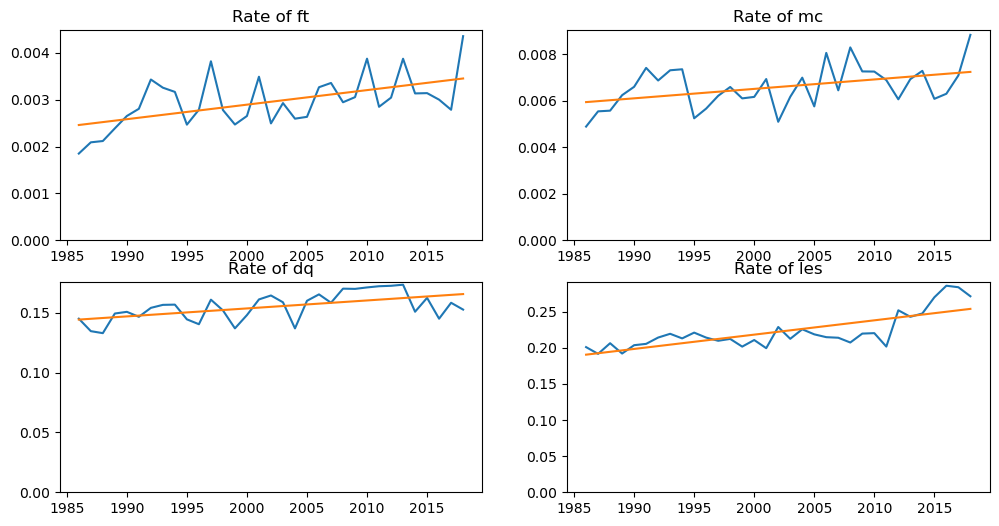

In [53]:
fig = prediction_graphing.plot_frequency_line_all_cats(df)
fig.savefig("figures/line_graphs_with_trends.pdf", bbox_inches="tight")

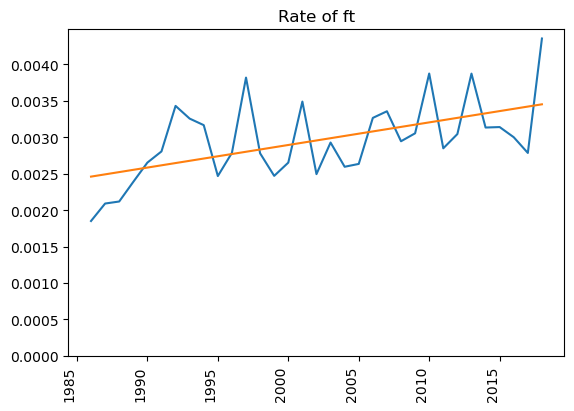

In [45]:
fig = prediction_graphing.plot_frequency_line_with_trend(df, "ft")
fig.savefig("figures/test_fig.pdf")

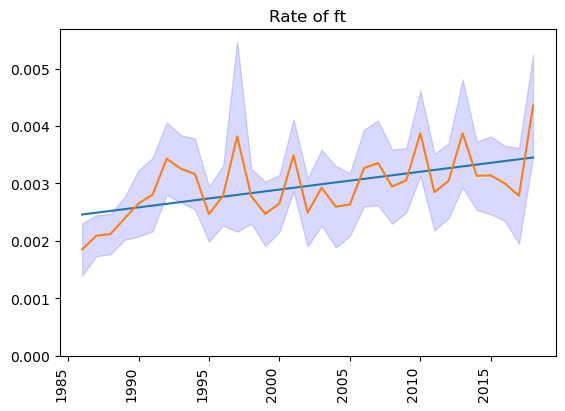

In [21]:
plot_rates_with_ci(df, "ft")

Orange is term average of opinion-level category rates (but these rates themselves are predictions).
Light blue/purple is 95% confidence interval.
Blue is least squares trendline.

This is measurement issue (measurement uncertainty and sampling uncertainty)

Don't have to diagnose/solve the potential "trend is artifact of predicting on earlier data than training data" issue

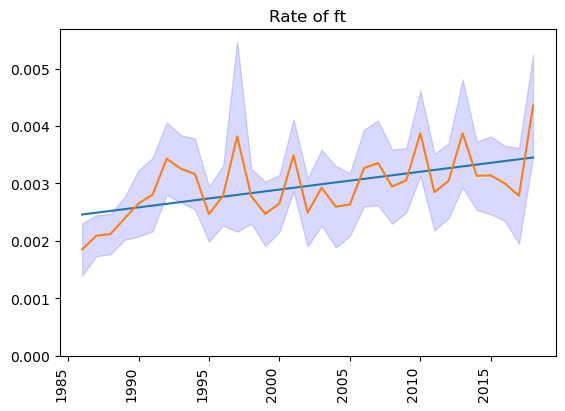

In [110]:
cat = "ft"
plot_rates_with_ci(df_18, cat)

[ 6.66426570e-04 -1.17920851e+00]


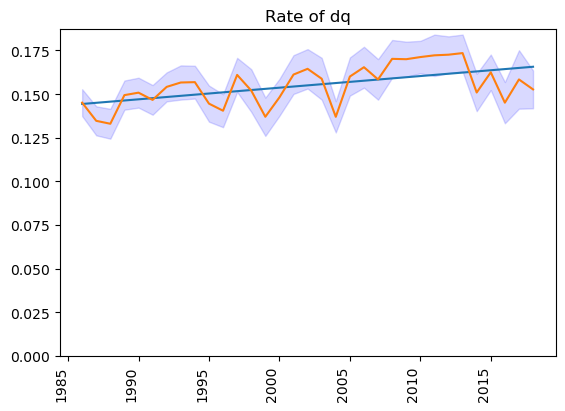

In [73]:
plot_rates_with_ci(df_18, "dq")

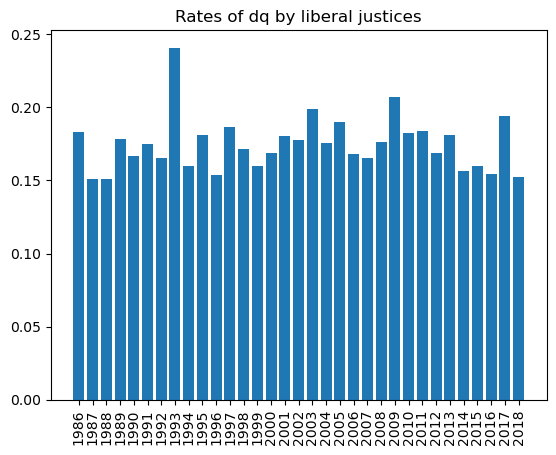

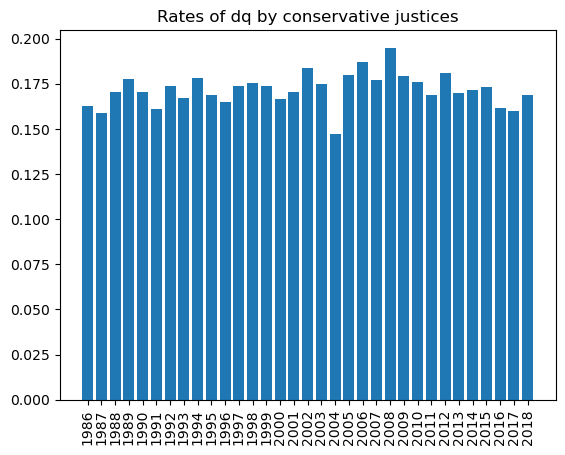

In [71]:
def plot_frequency_by_term_and_ideology(category, ideology, df):
    authors_of_interest = [author for author in authors.JUSTICE_TO_IDEOLOGY
                           if authors.JUSTICE_TO_IDEOLOGY[author] == ideology]
    df_sample = df[df["author"].isin(authors_of_interest)]
    cat_by_term = dict(df_sample.groupby(["term"])[category].sum())
    tokens_by_term = dict(df_sample.groupby(["term"])["tokens"].sum())
    frequencies_by_term = [cat_by_term[term] / tokens_by_term[term] for term in cat_by_term]
    plt.xticks(rotation=90)
    plt.bar(cat_by_term.keys(), frequencies_by_term)
    title = f"Rates of {category} by {ideology} justices"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
plot_frequency_by_term_and_ideology("dq","liberal", df_18)
plot_frequency_by_term_and_ideology("dq","conservative", df_18)

TODO: get sets of predicted focal terms by year

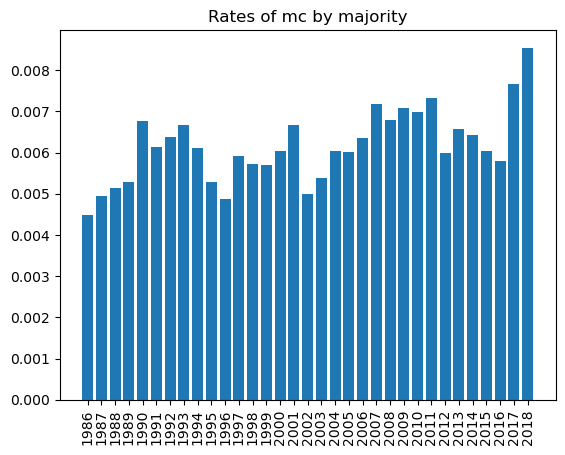

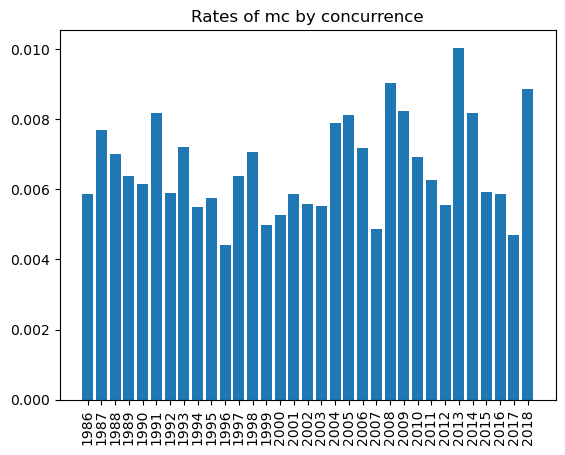

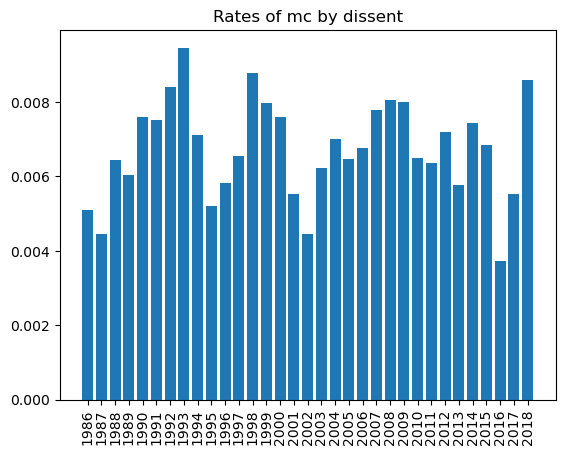

In [114]:
def plot_frequency_by_type(category, op_type, df):

    df_sample = df[df["opinion_type"] == op_type]
    cat_by_term = dict(df_sample.groupby(["term"])[category].sum())
    tokens_by_term = dict(df_sample.groupby(["term"])["tokens"].sum())
    frequencies_by_term = [cat_by_term[term] / tokens_by_term[term] for term in cat_by_term]
    plt.xticks(rotation=90)
    plt.bar(cat_by_term.keys(), frequencies_by_term)
    title = f"Rates of {category} by {op_type}"
    plt.title(title)
    plt.savefig(f"figures/{title}.pdf")
    plt.show()
cat = "mc"
plot_frequency_by_type(cat,"majority", df_18)
plot_frequency_by_type(cat,"concurrence", df_18)
plot_frequency_by_type(cat,"dissent", df_18)